In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from solver import CaptioningSolver
from model import CaptionGenerator
from utils import load_coco_data, decode_captions

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
small_data = load_coco_data('small_data.pkl')
word_to_idx = small_data['word_to_idx']

train_image_filename <type 'numpy.ndarray'> (21,) <U31
idx_to_word <type 'dict'> 1259
train_captions <type 'numpy.ndarray'> (100, 17) int32
train_image_idxs <type 'numpy.ndarray'> (100,) int32
train_features <type 'numpy.ndarray'> (21, 196, 512) float64
word_to_idx <type 'dict'> 1259


In [3]:
model = CaptionGenerator(word_to_idx, batch_size= 10, dim_feature=[196, 512], dim_embed=128,
                                   dim_hidden=128, n_time_step=16, cell_type='rnn', dtype=tf.float32)

In [12]:
solver = CaptioningSolver(model, small_data, n_epochs=100, batch_size=10, update_rule='adam',
                                      learning_rate=0.004, print_every=10, save_every=100, image_path='./data/train2014_resized',
                                pretrained_model=None, model_path='./model/', test_model='./model/model-200')

In [10]:
#decode_captions(small_data['train_captions'], small_data['idx_to_word'])[10:70]

num epochs: 100
iterations per epoch: 10
data size: 100
batch size: 10

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Initial Train Loss: 814.47699
Generated Caption: orange poses brushing electronics pickup poses pickup sidewalk poses pickup pickup pickup pickup pickup pickup pickup
Generated Caption: sandwiches signal snowboarders mug persons with roll with roll soccer roll roll roll roll roll roll
Generated Caption: cats cats bat cats refrigerator cats cats stream cats cats cats cats cats cats cats cats
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Train Loss at Epoch 10: 252.44431
Generated Caption: a number of people on on a bench with a bench <END>
Generated Caption: a together a around a food food around of a table <END>
Generated 

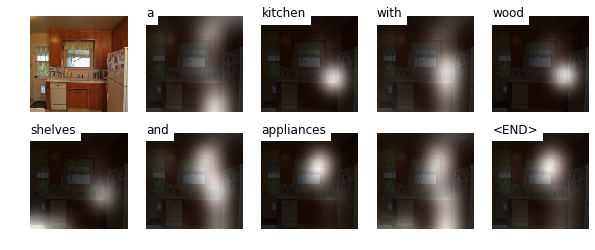

Sampled Caption: young men sit next to each other working on laptops  <END>


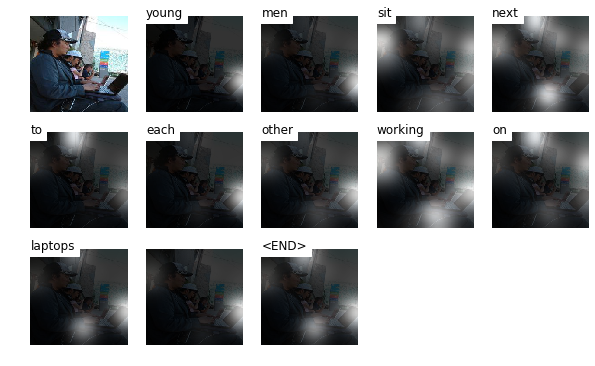

Sampled Caption: a very cluttered but very clean <UNK> kitchen <END>


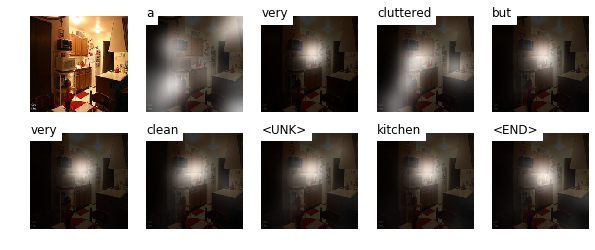

Sampled Caption: a man in a <UNK> and glasses leans over a counter <END>


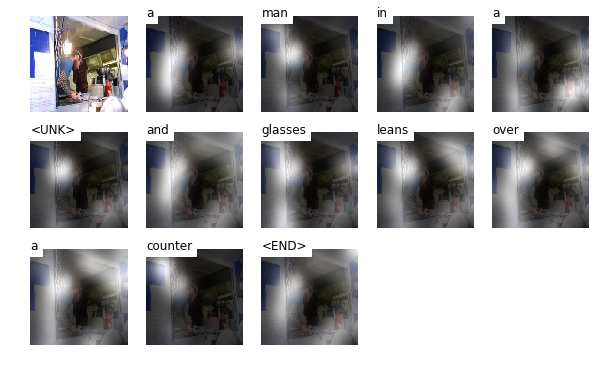

Sampled Caption: some men standing around a counter while making a pizza  <END>


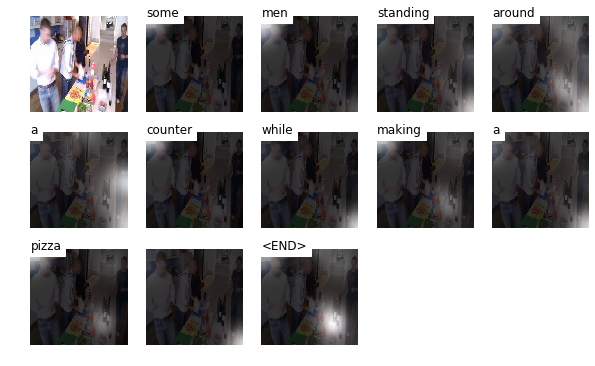

Sampled Caption: the kitchen is full of <UNK> on the rack <END>


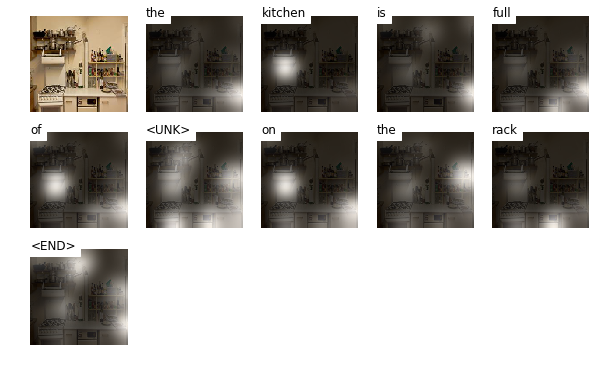

Sampled Caption: man cutting a hot piece of meat on a cutting board  <END>


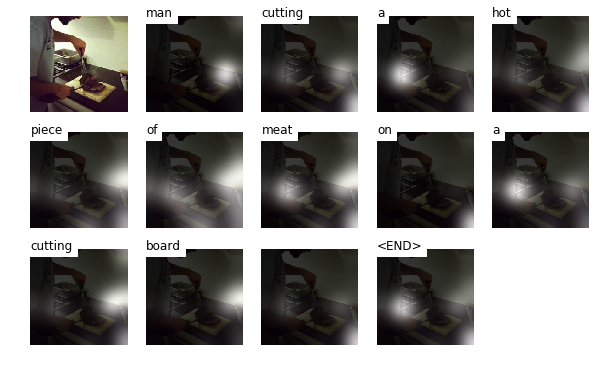

Sampled Caption: some men standing around a counter while making a pizza  <END>


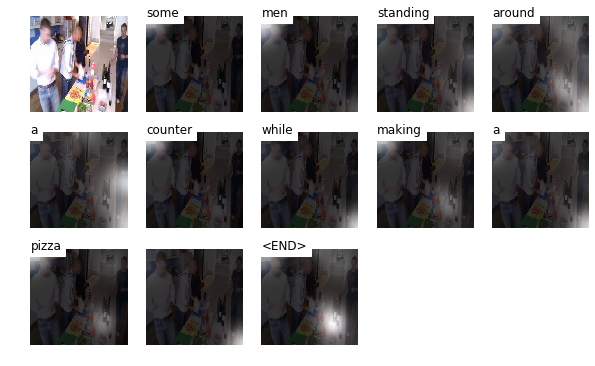

Sampled Caption: a man cutting up <UNK> at an outdoor table  <END>


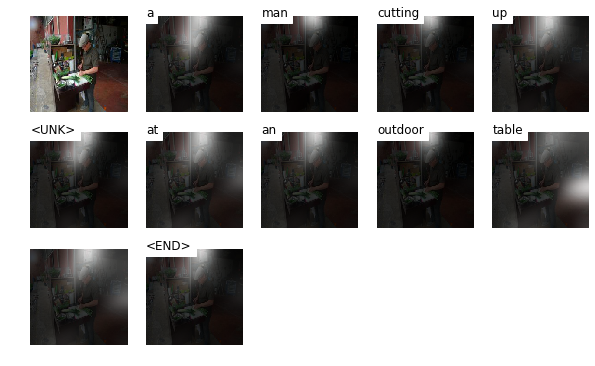

Sampled Caption: a room filled with wooden table and chairs <END>


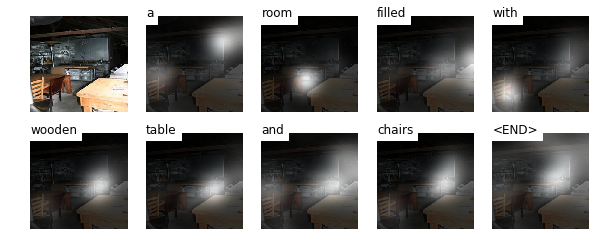

In [13]:
solver.train()

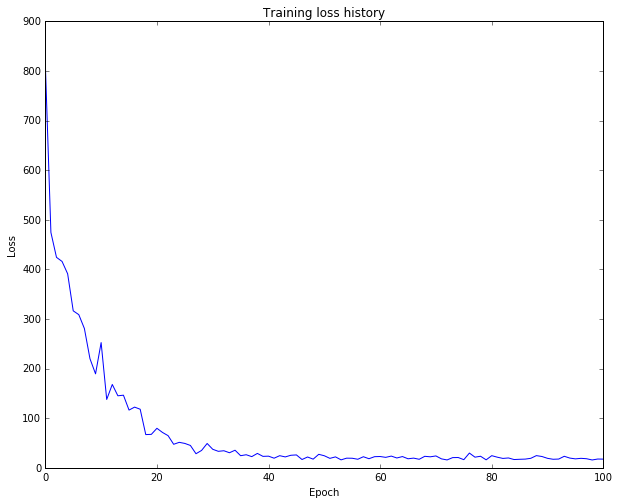

In [14]:
# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()